# Analysis of results from simulated data
Deeper look into a model's performance on simulated data.

In [1]:
# Imports
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from master_scripts.data_functions import (load_experiment, get_git_root, separation_distance, energy_difference,
                                           relative_energy, event_indices, normalize_image_data)
from master_scripts.analysis_functions import (doubles_classification_stats, singles_classification_stats)
%load_ext autoreload
%autoreload 2
repo_root = get_git_root()

## Data and experiment import
Load the image data and split into training and validation sets. Since we specify the random seed, we can
reproduce the exact same data the model was originally validated on to explore it.

In [2]:
images = np.load(repo_root + "data/simulated/images_full_pixelmod.npy")
positions = np.load(repo_root + "data/simulated/positions_full.npy")
energies = np.load(repo_root + "data/simulated/energies_full.npy")
labels = np.load(repo_root + "data/simulated/labels_full.npy")

In [3]:
# Load experiment and associated model (must be a saved model instance complete with weights)
#experiment_id = "40350020681b"
experiment_id = "9886d077068a"
experiment = load_experiment(experiment_id)
model = tf.keras.models.load_model(repo_root + "models/" + experiment_id + ".h5")
# Print experiment metrics
print("==== Experiment metrics")
print(json.dumps(experiment["metrics"], indent=2))
print("====")

==== Experiment metrics
{
  "accuracy_score": 0.9832926315789474,
  "confusion_matrix": {
    "TN": 236349,
    "FP": 1183,
    "FN": 6753,
    "TP": 230715
  },
  "f1_score": 0.9830920859201562,
  "matthews_corrcoef": 0.9668510918102141,
  "roc_auc_score": 0.9928096454052002
}
====


## Predict on validation data

In [4]:
x_idx = np.arange(len(images))
train_idx, val_idx = train_test_split(
    x_idx,
    random_state=experiment['experiment_config']['random_seed']
)   
# Predict on the validation set
prediction = model.predict(normalize_image_data(images[val_idx]))
val_pred = (prediction > 0.5).astype(int)

# Single events
## Descriptive stats on validation data

In [5]:
singles = singles_classification_stats(positions[val_idx], energies[val_idx], val_pred)

In [6]:
# group by classification
sstats = singles[singles.columns[:-1]].groupby('classification')
# Aggregate the desired statistics into a new df
sstats = sstats.agg([np.mean, np.std, np.median]).applymap('{:.3f}'.format)
print(json.dumps(experiment['metrics']['confusion_matrix'], indent=2))
display(sstats)

{
  "TN": 236349,
  "FP": 1183,
  "FN": 6753,
  "TP": 230715
}


x_pos                y_pos               energy              
                 mean    std median   mean    std median   mean    std median
classification                                                               
0               7.991  4.233  7.993  8.003  4.232  8.004  0.499  0.289  0.498
1               8.428  4.310  8.654  7.430  4.023  7.303  0.742  0.199  0.779

## Plot some desired number of misclassified single event

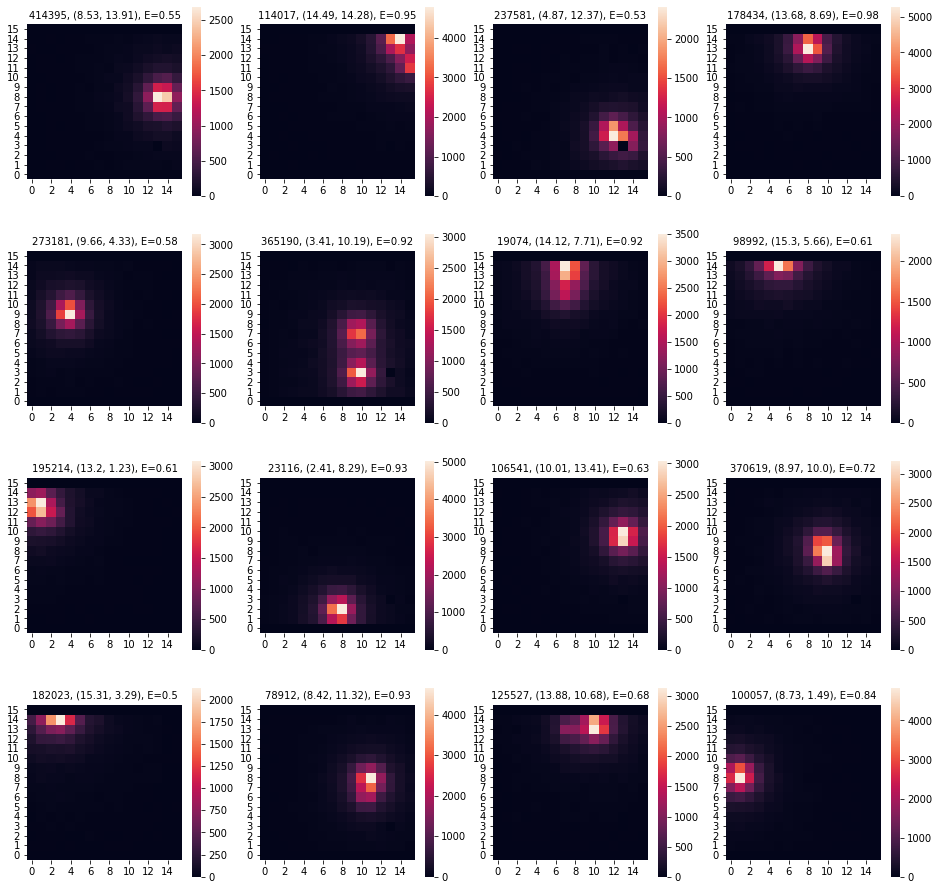

In [7]:
n_events = 16
s_mc = singles.loc[singles['classification'] == 1]
selected = np.random.choice(s_mc['indices'].values, n_events, replace=False)
fig, ax = plt.subplots(np.ceil(n_events/4).astype(np.int32), 4, figsize=(16, 16))
for i, idx in enumerate(selected):
    a = ax.flatten()[i]
    event = s_mc.loc[s_mc['indices'] == idx]
    x = event['x_pos'].values[0].round(2)
    y = event['y_pos'].values[0].round(2)
    energy = event['energy'].values[0].round(2)
    sns.heatmap(images[val_idx][idx].reshape(16, 16), square=True, ax=a)
    #a.text(0, 15 + 0.6, f"",
    #    fontsize=8,
    #    color='white'
    #    )
    a.set_title(f"{idx}, ({x}, {y}), E={energy}", fontsize=10)
    a.invert_yaxis()

In [8]:
# Check positions if all misclassified single events
print(np.count_nonzero(positions[val_idx][s_mc['indices'].values, 2] != -100))

0


## Distribution of positions and energies
Where are the misclassified singles located, and what are their energies?

Text(0.5, 1.0, 'Locations of misclassified single events')

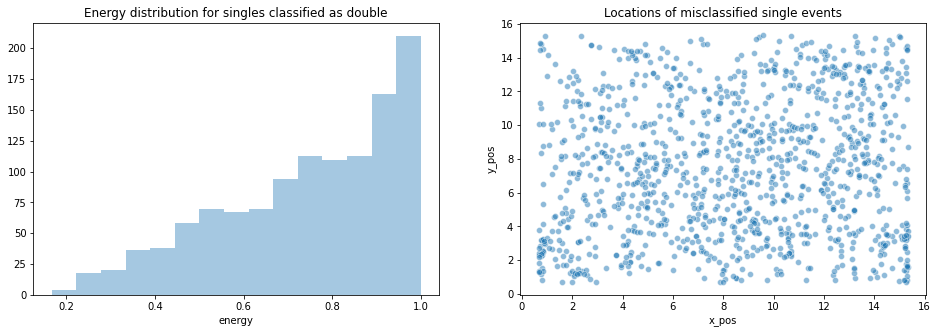

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.distplot(s_mc['energy'], kde=False, ax=ax[0])
sns.scatterplot(s_mc['x_pos'], s_mc['y_pos'], alpha=0.5, ax=ax[1])
ax[0].set_title("Energy distribution for singles classified as double")
ax[1].set_title("Locations of misclassified single events")

# Double events
## Descriptive statistics on validation data

In [196]:
# Load dataframes
doubles = doubles_classification_stats(positions[val_idx], energies[val_idx], val_pred)

In [315]:
# Group by close events, then by which class the event was classified as
dstats = doubles[doubles.columns[:-1]].groupby(['close', 'classification'])
# Aggregate the desired statistics into a new df
dstats = dstats.agg([np.mean, np.std, np.median, np.min, np.max]).applymap('{:.3f}'.format)
print(json.dumps(experiment['metrics']['confusion_matrix'], indent=2))
display(dstats)

{
  "TN": 236349,
  "FP": 1183,
  "FN": 6753,
  "TP": 230715
}


separation distance                               \
                                    mean    std median   amin    amax   
close classification                                                    
False 0                            4.522  3.417  3.378  1.000  18.195   
      1                            7.823  3.546  7.661  1.000  19.713   
True  0                            0.640  0.236  0.670  0.021   1.000   
      1                            0.695  0.231  0.733  0.021   1.000   

                     relative energy                                      \
                                mean       std median   amin        amax   
close classification                                                       
False 0                      197.272  3464.083  1.171  0.000  228094.700   
      1                        2.553     7.967  1.000  0.003    1185.119   
True  0                        7.250    53.580  0.972  0.001    1449.956   
      1                        1.327     2.281  0.997  0.073      76.363   

                     energy difference                              
                                  mean    std median   amin   amax  
close classification                                                
False 0                          0.542  0.278  0.573  0.001  0.996  
      1                          0.329  0.232  0.289  0.000  0.993  
True  0                          0.372  0.248  0.339  0.000  0.992  
      1                          0.298  0.210  0.261  0.000  0.892

## Distributions and scatterplot

In [303]:
dgroup = doubles.groupby(['close', 'classification'])

### Comparing correct and misclassified double events
#### Separation distances

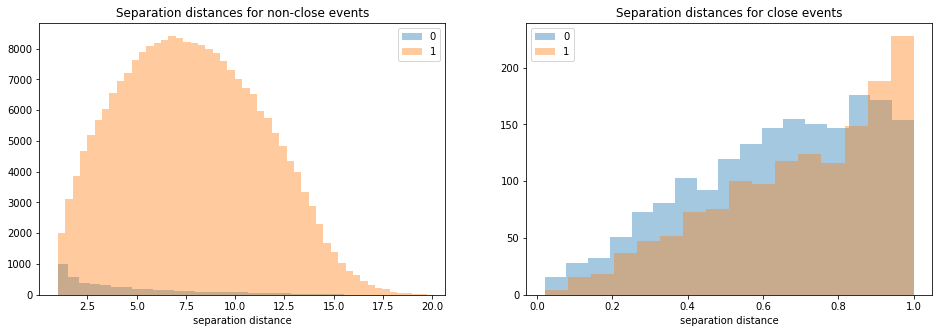

In [306]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
keys = list(dgroup.groups.keys())
sns.distplot(dgroup.get_group(keys[0])['separation distance'], kde=False, label=keys[0][1], ax=ax[0])
sns.distplot(dgroup.get_group(keys[1])['separation distance'], kde=False, label=keys[1][1], ax=ax[0])
sns.distplot(dgroup.get_group(keys[2])['separation distance'], kde=False, label=keys[2][1], ax=ax[1])
sns.distplot(dgroup.get_group(keys[3])['separation distance'], kde=False, label=keys[3][1], ax=ax[1])
ax[0].set_title("Separation distances for non-close events")
ax[0].legend()
ax[1].set_title("Separation distances for close events")
ax[1].legend()

#### Relative energy

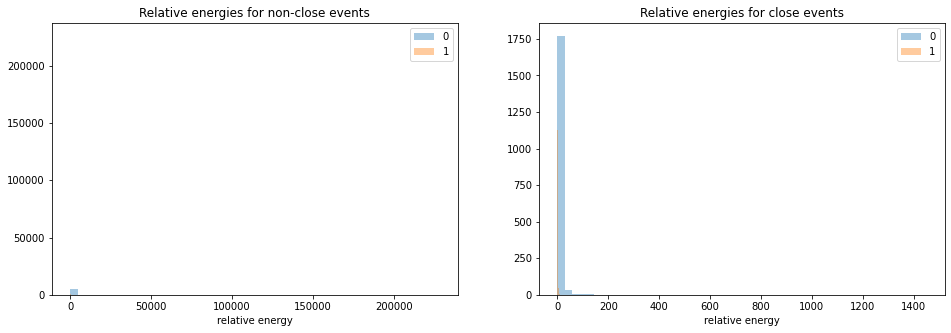

In [314]:
dgroup = doubles.groupby(['close', 'classification'])
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
keys = list(dgroup.groups.keys())
bins = 
sns.distplot(dgroup.get_group(keys[0])['relative energy'], kde=False, label=keys[0][1], ax=ax[0])
sns.distplot(dgroup.get_group(keys[1])['relative energy'], kde=False, label=keys[1][1], ax=ax[0])
sns.distplot(dgroup.get_group(keys[2])['relative energy'], kde=False, label=keys[2][1], ax=ax[1])
sns.distplot(dgroup.get_group(keys[3])['relative energy'], kde=False, label=keys[3][1], ax=ax[1])
ax[0].set_title("Relative energies for non-close events")
ax[0].legend()
ax[1].set_title("Relative energies for close events")
ax[1].legend()

#### Energy difference

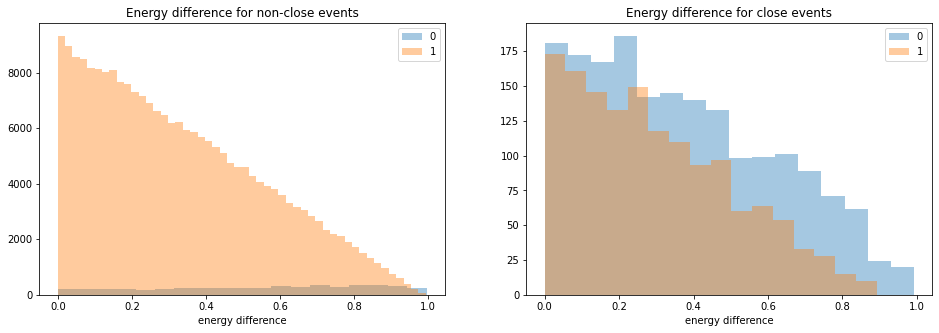

In [311]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
keys = list(dgroup.groups.keys())
sns.distplot(dgroup.get_group(keys[0])['energy difference'], kde=False, label=keys[0][1], ax=ax[0])
sns.distplot(dgroup.get_group(keys[1])['energy difference'], kde=False, label=keys[1][1], ax=ax[0])
sns.distplot(dgroup.get_group(keys[2])['energy difference'], kde=False, label=keys[2][1], ax=ax[1])
sns.distplot(dgroup.get_group(keys[3])['energy difference'], kde=False, label=keys[3][1], ax=ax[1])
ax[0].set_title("Energy difference for non-close events")
ax[0].legend()
ax[1].set_title("Energy difference for close events")
ax[1].legend()

In [ ]:
dist_bins = np.arange(0, np.amax(rel_distance_test), 0.5)
energy_bins = np.arange(0, np.amax(energy_diff_test), 0.02)
fig, ax = plt.subplots(1, 2, figsize=(12,4))
ax[0].hist(rel_distance_test[double_indices][correct_doubles], bins=dist_bins, alpha=0.5, label="correct")
ax[0].hist(rel_distance_test[double_indices][wrong_doubles], bins=dist_bins, alpha=0.5, label="wrong")
ax[0].set_title("Distribution of separation distances\n for classified double events")
ax[0].set_xlabel("Separation distance [mm]")
ax[0].set_ylabel("Number of events")
ax[0].legend()
ax[1].hist(rel_energy_test[double_indices][correct_doubles], bins=energy_bins, alpha=0.5, label="correct")
ax[1].hist(rel_energy_test[double_indices][wrong_doubles], bins=energy_bins, alpha=0.5, label="wrong")
ax[1].set_title("Distribution of relative energy \n for classified double events")
ax[1].set_xlabel("Relative energy")
ax[1].set_ylabel("Number of events")
ax[1].legend()
fig.savefig(FIGURE_PATH+net+"_relative_test_compare.pdf", format="pdf")

In [ ]:
dist_bins = np.arange(0, np.amax(rel_distance_test), 0.5)
energy_bins = np.arange(0, 10, 0.1)
fig, ax = plt.subplots(1, 2, figsize=(12,4))
#ax[0].hist(rel_distance_test[double_indices][correct_doubles], bins=dist_bins, alpha=0.5, label="correct")
ax[0].hist(rel_distance_test[double_indices][wrong_doubles], bins=dist_bins, alpha=0.5, label="wrong")
ax[0].set_title("Distribution of Relative distances\n for classified double events")
ax[0].set_xlabel("Relative distance [mm]")
ax[0].set_ylabel("Number of events")
ax[0].legend()
#ax[1].hist(rel_energy_test[double_indices][correct_doubles], bins=energy_bins, alpha=0.5, label="correct")
#ax[1].hist(rel_energy_test[double_indices][wrong_doubles], bins=energy_bins, alpha=0.5, label="wrong")
ax[1].hist(rel_energy_test[double_indices][wrong_doubles], label="wrong")
ax[1].set_title("Distribution of relative energy \n for classified double events")
ax[1].set_xlabel("Relative energy")
ax[1].set_ylabel("Number of events")
ax[1].legend()
fig.savefig(FIGURE_PATH+net+"_relative_test_compare.pdf", format="pdf")

### Scatterplot relative distance vs. relative energy

In [ ]:
plt.scatter(
    rel_distance_test[double_indices][wrong_doubles], 
    rel_energy_test[double_indices][wrong_doubles],
    marker='.',
    )
plt.title("Separation distance vs. relative energy for misclassified double events")
plt.xlabel("Separation distance [mm]")
plt.ylabel("Relative energy")
plt.show()

# Distribution of position around highest intensity pixel
In previous work data analysis showed that most event positions are within the highest intensity pixel,
and all (verify!) events are within the two highest intensity pixels,
It might be reasonable to look at how the predicted positions are distributed around the highest intensity
pixel.

In [ ]:
# Reshape input array to a 2D array with rows being kept as with original array.
# Then, get idnices of max values along the columns.
pix_hmap = np.zeros(images[0].shape)
max_idx = images.reshape(images.shape[0],-1).argmax(1)
# Get unravel indices corresponding to original shape of A
maxpos_vect = np.column_stack(np.unravel_index(max_idx, images[0,:,:].shape))
np.add.at(
    pix_hmap, 
    (
        maxpos_vect[:, 0],
        maxpos_vect[:, 1],
        maxpos_vect[:, 2]
    ),
    1
)
#pix_hmap[maxpos_vect[:, 0], maxpos_vect[:, 1], maxpos_vect[:, 2]] += 1
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Heatmap of highest intensity pixels in dataset')
sns.heatmap(pix_hmap.reshape((16,16)), ax=ax, square=True)

In [ ]:
imgs = images[single_indices].reshape(images[single_indices].shape[0],16,16)

# get index of highest energy pixel
print(np.unravel_index(np.argmax(imgs[0], axis=None), imgs[0].shape))
fix, ax = plt.subplots()
ax.imshow(imgs[0])
ax.plot(0,0, 'rx')

In [ ]:
config = {
    "DATA_PATH": "../../data/real/anodedata.txt",              
    "MODEL_PATH": "../../data/output/models/",                
    "CLASSIFIER": "Project-0.97.hdf5",                      
    "SINGLE_ENERGY_MODEL": "single_energy_model_name.hdf5",    
    "SINGLE_POSITION_MODEL": "single_position_model_name.hdf5",
    "DOUBLE_ENERGY_MODEL": "double_energy_model_name.hdf5",    
    "DOUBLE_POSITION_MODEL": "double_position_model_name.hdf5" 
}

data = import_real_data(config)
print(data['image'].type)
